In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import os
import sys
from PIL import Image
from datetime import date, datetime, timedelta

sys.path.insert(0, '..')
from utils import fs, mongodb, str_yesterday, str_today, parse_datas
from bboxes_to_yolo import cursor_images_and_bboxes, extract_yolo


## Gera base de dados YOLO (v2 - labelImg)

In [2]:
#if os.path.exists('yolo'):
#    shutil.rmtree('yolo')

In [3]:
start = datetime(2020, 3, 2)
end = datetime.today()
limit = 1000
#cursor = cursor_images_and_bboxes(db, start, end, limit)
#extract_yolo(cursor)

### Instruções para conversão para yolov3

Está sendo utilizado para rotulagem manual e revisão da rotulagem o aplicativo labelImg. Como este utiliza formato de anotação Pascal VOC ou Yolo V2, foi optado por gerar anotação modelo YOLO v2.

Entretanto, no treinamento está sendo utilziado YOLO v3. Em scripts/ tem um arquivo para converter yolov2 para v3 e em README-yolo.md tem as instruções detalhadas de utilização e de instalação e uso de um modelo de referência yolov3.

## Confere anotações

In [4]:
# YOLO v3
with open('../../yolo_weights/container_train.txt') as yolov3_in:
    arquivos = yolov3_in.readlines()


['../bases/yolo/5e67b032635812f4b02916f6/5e67b032635812f4b02916f6.jpg', '612,71,1426,673,0']
612 71 1426 673


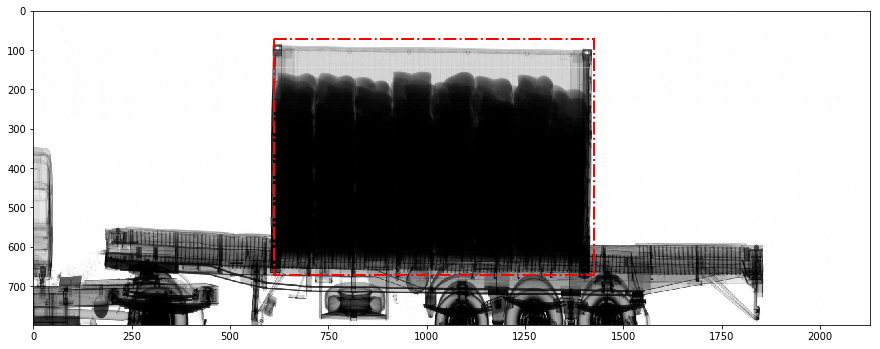

In [5]:
linha = random.choice(arquivos).split()
print(linha)
arquivo = linha[0]
xmin, ymin, xmax, ymax, classe = map(int, linha[1].split(','))
print(xmin, ymin, xmax, ymax)
image = Image.open(os.path.join('..', arquivo))
fig, ax = plt.subplots(1, figsize=(15, 12))
ax.imshow(image)
box = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, edgecolor='r',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)

## Carregar e montar modelo

In [6]:
sys.path.append('../../keras-yolo3')

In [7]:
from yolo import YOLO

Using TensorFlow backend.


In [8]:
yolo = YOLO(
    model_path='../../keras-yolo3/logs/000/trained_weights_final.h5',
    anchors_path='../../keras-yolo3/model_data/yolo_anchors.txt',
    classes_path='../../keras-yolo3/model_data/container_classes.txt',
)


../../keras-yolo3/model_data/container_classes.txt
../../keras-yolo3/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [9]:
print([atrib for atrib in dir(yolo) if atrib[:2] !='__'])

['_defaults', '_get_anchors', '_get_class', 'anchors', 'anchors_path', 'boxes', 'class_names', 'classes', 'classes_path', 'close_session', 'colors', 'detect_image', 'generate', 'get_defaults', 'gpu_num', 'input_image_shape', 'iou', 'model_image_size', 'model_path', 'predict_array', 'predict_image', 'score', 'scores', 'sess', 'yolo_model']


In [10]:
model = yolo.yolo_model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [11]:
with open('../../yolo_weights/container_train.txt') as yolov3_in:
    arquivos = yolov3_in.readlines()

In [29]:
linha = random.choice(arquivos).split()
print(linha)
arquivo = linha[0]
xmin, ymin, xmax, ymax, classe = map(int, linha[1].split(','))
print(xmin, ymin, xmax, ymax)
image = Image.open(os.path.join('..', arquivo))

['../bases/yolo/5e67b034635812f4b029192b/5e67b034635812f4b029192b.jpg', '131,21,2477,677,0']
131 21 2477 677


In [30]:
xfinal, yfinal = image.size
print(xfinal, yfinal)
resized = image.resize(yolo.model_image_size, Image.LANCZOS)
print(resized.size)
image_data = np.array(resized, dtype='float32')
print(image_data.shape)
image_data /= 255.
image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

2747 799
(416, 416)
(416, 416, 3)


In [31]:
out_boxes, out_scores, out_classes = yolo.predict_image(resized)

(416, 416, 3)
Found 20 boxes for img


In [32]:
# out_boxes, out_scores, out_classes = yolo.predict_image(image)

In [33]:
# out_boxes, out_scores, out_classes = yolo.predict_array(image_data, (resized.size[1], resized.size[0]))

In [34]:
print(out_boxes, out_scores, out_classes)

[[-33.802567    1.0157893 128.41661   100.36267  ]
 [ 24.009062  305.03116   134.0971    429.381    ]
 [ 56.340054  145.37088   168.30965   268.2341   ]
 [ 55.89678   208.4642    168.69879   333.1765   ]
 [-28.21002    39.603058  121.79345   129.04718  ]
 [ 29.9286    110.32407   129.50996   240.087    ]
 [ 31.331545   43.203705  128.27171   179.32166  ]
 [ 29.853691  174.50795   129.50838   303.9002   ]
 [ 55.563652   80.333565  169.12117   205.33257  ]
 [ 37.799797   43.84187   182.75307   121.2789   ]
 [-26.640608  171.04326   119.12706   252.14911  ]
 [-26.843912  139.35384   119.351845  219.92328  ]
 [ 25.966074  237.87326   132.99661   368.585    ]
 [-26.652615  203.13217   119.10463   284.10037  ]
 [-26.130783  106.897125  118.713554  188.40906  ]
 [-26.323095  234.95349   118.70976   316.2374   ]
 [ 82.950806  309.9377    202.99973   423.2637   ]
 [120.7625    177.70914   232.45018   300.13712  ]
 [120.91705   113.45378   232.36115   236.47311  ]
 [155.07364   146.24338   262.7

In [35]:
xmin_pred, ymin_pred, xmax_pred, ymax_pred = out_boxes[0]
xmin_pred = int(xmin_pred * xfinal / 416)
xmax_pred = int(xmax_pred * xfinal / 416)
ymin_pred = int(ymin_pred * yfinal / 416)
ymax_pred = int(ymax_pred * yfinal / 416)
print(xmin_pred, ymin_pred, xmax_pred, ymax_pred)

-223 1 847 192


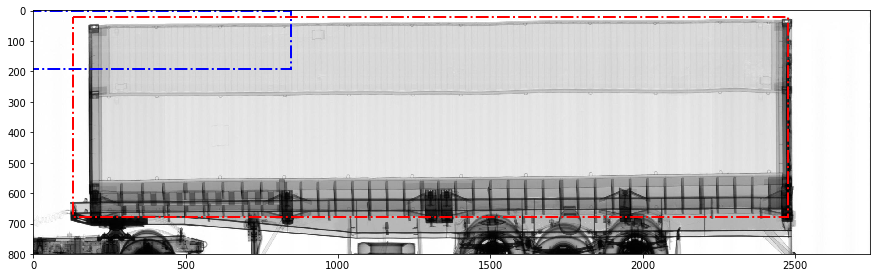

In [36]:
fig, ax = plt.subplots(1, figsize=(15, 12))
ax.imshow(image)
box = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, edgecolor='r',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)
box = patches.Rectangle((xmin_pred, ymin_pred), xmax_pred - xmin_pred, ymax_pred - ymin_pred,
                        fill=False, edgecolor='b',
                        linewidth=2, linestyle='dashdot')
ax.add_patch(box)


## Tensorflow Serving

In [20]:
import tensorflow as tf
with yolo.sess.as_default():
    yolo.sess.run(tf.global_variables_initializer())
    tf.saved_model.simple_save(yolo.sess,
    'yolov3',
    inputs={'input_image': yolo.yolo_model.input, 'image_shape': yolo.input_image_shape},
    outputs={t.name: t for t in [yolo.boxes, yolo.scores, yolo.classes]})

AttributeError: module 'tensorflow.python.saved_model.saved_model' has no attribute 'simple_save'

In [ ]:
import keras

In [ ]:
keras.models.save_model